In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("betodds.csv", header = 0, index_col = 0, encoding = "cp1252", sep = ";")

c:\users\trabelsi\appdata\local\continuum\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [435]:
data.head()

,scheduled_off,Unnamed: 2,Unnamed: 3,Unnamed: 4,full_description,competition,competition_type,event_name,winner,1,...,favorite_flag,favorite_win,IP_1,IP_x,IP_2,team1,team2,pnl_1,pnl_x,pnl_2
Id,,,,,,,,,,,,,,,,,,,,,
70594,28.12.2014 22:00,28.12.2014,28.12.2014,28.12.2014,Antigua and Barbuda/Antigua and Barbuda Premie...,Antigua and Barbuda Premier Division,Antigua and Barbuda,Greenbay Hoppers FC v SAP FC,1,2.5,...,1,1,IP,IP,IP,Greenbay Hoppers FC,SAP FC,14.25,-10.0,-10.000
103739,29.12.2014 11:30,29.12.2014,29.12.2014,29.12.2014,Egyptian Soccer/Egyptian Premier/Fixtures 29 D...,Egyptian Premier,Egyptian Soccer,Alaab Damanhour v Zamalek,2,12,...,2,1,IP,IP,IP,Alaab Damanhour,Zamalek,-10.00,-10.0,3.515
103740,29.12.2014 11:50,29.12.2014,29.12.2014,29.12.2014,Jamaican Soccer/Jamaican Premier League/Fixtur...,Jamaican Premier League,Jamaican Soccer,Boys Town FC v Harbour View FC,1,2.9,...,1,1,PE,PE,PE,Boys Town FC,Harbour View FC,18.05,-10.0,-10.000
103741,29.12.2014 18:00,29.12.2014,29.12.2014,29.12.2014,Scottish Soccer/SPFL Development League 2/Fixt...,SPFL Development League 2,Scottish Soccer,E Stirling (Youth) v Stenhousemuir U20,2,1.65,...,1,0,IP,IP,IP,E Stirling (Youth),Stenhousemuir U20,-10.00,-10.0,38.000
103742,29.12.2014 14:00,29.12.2014,29.12.2014,29.12.2014,Egyptian Soccer/Egyptian Premier/Fixtures 29 D...,Egyptian Premier,Egyptian Soccer,ENPPI v Al Masry,2,1.31,...,1,0,IP,IP,IP,ENPPI,Al Masry,-10.00,-10.0,53.200


In [2]:
def split_team(s, i):
    if isinstance(s, str):
        teams = s.split(" v ")
        if len(teams) > i:
            return teams[i]
        else:
            return None
    else:
        return None

data["team1"] = data["event_name"].apply(lambda x: split_team(x,0))
data["team2"] = data["event_name"].apply(lambda x:split_team(x, 1))


In [3]:
def pnl_per_runner(data, fee = 0.05, stake = 10):
    data = data.copy()
    targets = ["1","x","2"]
    for target in targets:
        pls = []
        for i, odds in data.iterrows():
                pl = ((float(odds[target]) - 1) * stake) * (1 - fee) if target == odds["winner"] else -stake 
                pls.append(pl)

        data["pnl_"+target] = pls
    return data

data = pnl_per_runner(data)

In [390]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib

data_preprocessing = data[["team1","team2","1","x","2","pnl_1","pnl_x","pnl_2", "winner"]]
data_preprocessing = data_preprocessing[data_preprocessing.astype(str) != "\\N"].dropna().copy()
all_teams = list(data_preprocessing["team1"].values) + list(data_preprocessing["team2"].values) 
le = LabelEncoder()
le.fit(all_teams)

joblib.dump(le, 'encoder.pkl') 
print("saved model to encoder.pkl")

data_preprocessing["team1_label"] = le.transform(data_preprocessing["team1"])
data_preprocessing["team2_label"] = le.transform(data_preprocessing["team2"])

data_preprocessing["1"] = data_preprocessing["1"].astype(float)
data_preprocessing["x"] = data_preprocessing["x"].astype(float)
data_preprocessing["2"] = data_preprocessing["2"].astype(float)

data_preprocessing["prob_1"] = 1/data_preprocessing["1"]
data_preprocessing["prob_x"] = 1/data_preprocessing["x"]
data_preprocessing["prob_2"] = 1/data_preprocessing["2"]


saved model to encoder.pkl


In [386]:
data_fit = data_preprocessing.iloc[:70000].copy()
data_cv = data_preprocessing.iloc[70001:100000].copy()
data_out = data_preprocessing.iloc[100001:].copy()

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import metrics
from sklearn.externals import joblib
clf = RandomForestRegressor(max_depth=10, n_estimators=20, max_features=5, random_state = 1)
predictors = ["team1_label","team2_label","1", "x", "2"]

#clf = linear_model.LinearRegression()
#predictors = ["1", "x", "2"]


def prediction(data_fit, data_out, target, clf, predictors, save = None):
    X = data_fit[predictors]
    Y = data_fit[target]
    #Y = data_fit["winner"] == "x"
    X_out = data_out[predictors]
    Y_out = data_out[target]
    #clf = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=3)
    
    clf.fit(X,Y)
    Y_estim = clf.predict(X)
    Y_pred = clf.predict(X_out)
    
    print("absolute error of fit")
    print(metrics.mean_absolute_error(Y_estim, Y))
    print("absolute error of pred")
    print(metrics.mean_absolute_error(Y_pred, Y_out))
    print("r2 of fit")
    print(metrics.r2_score(Y_estim, Y))
    print("r2 of pred")
    print(metrics.r2_score(Y_pred, Y_out))
    
    if save is not None:
        joblib.dump(clf, save+'.pkl') 
        print("saved model to "+save+".pkl")
        
    return Y_pred

data_cv["pred_1"] = prediction(data_fit, data_cv, "pnl_1", clf, predictors, save = "predictor_1")
data_cv["pred_x"] = prediction(data_fit, data_cv, "pnl_x", clf, predictors, save = "predictor_x")
data_cv["pred_2"] = prediction(data_fit, data_cv, "pnl_2", clf, predictors, save = "predictor_2")


data_fit["pred_1"] = prediction(data_fit, data_fit, "pnl_1", clf, predictors)
data_fit["pred_x"] = prediction(data_fit, data_fit, "pnl_x", clf, predictors)
data_fit["pred_2"] = prediction(data_fit, data_fit, "pnl_2", clf, predictors)


data_out["pred_1"] = prediction(data_fit, data_out, "pnl_1", clf, predictors)
data_out["pred_x"] = prediction(data_fit, data_out, "pnl_x", clf, predictors)
data_out["pred_2"] = prediction(data_fit, data_out, "pnl_2", clf, predictors)


absolute error of fit
10.377101686
absolute error of pred
11.1046087933
r2 of fit
0.318306150805
r2 of pred
-0.418812815351
saved model to predictor_1.pkl
absolute error of fit
16.1989737244
absolute error of pred
20.1566169529
r2 of fit
0.37085237671
r2 of pred
-1.65157239817
saved model to predictor_x.pkl
absolute error of fit
13.0324247206
absolute error of pred
14.2213240835
r2 of fit
0.409826860043
r2 of pred
-11.9046187732
saved model to predictor_2.pkl
absolute error of fit
10.377101686
absolute error of pred
10.377101686
r2 of fit
0.318306150805
r2 of pred
0.318306150805
absolute error of fit
16.1989737244
absolute error of pred
16.1989737244
r2 of fit
0.37085237671
r2 of pred
0.37085237671
absolute error of fit
13.0324247206
absolute error of pred
13.0324247206
r2 of fit
0.409826860043
r2 of pred
0.409826860043
absolute error of fit
10.377101686
absolute error of pred
10.8155793594
r2 of fit
0.318306150805
r2 of pred
-0.450991434597
absolute error of fit
16.1989737244
absolute

In [385]:
def pnl_target(pred, fee = 0.05, stake = 10, max_odds = 2, min_odds = 1.2, 
               scale_with_pred = True, scale_with_odds = False, target_restrict = None,
              min_pred = 0):
    data = pred.copy()
    pls = []
    targets = []
    runners  = ["1","x","2"]
    for i, odds in data.iterrows():
        target = "1"
        for r in runners:
            if float(odds["pred_"+r]) > float(odds["pred_"+target]):
                target = r
        
        restricted = target_restrict is None or target in target_restrict
        
        if odds["pred_"+target] > min_pred and float(odds[target])<max_odds  and float(odds[target])>min_odds and restricted:
            stake_adjusted = stake
            
            if scale_with_odds:
                stake_adjusted = stake_adjusted / float(odds[target])
            
            if scale_with_pred:
                stake_adjusted = stake_adjusted * max(min(odds["pred_"+target], 5), 0.5)
                
            pl = ((float(odds[target]) - 1) * stake_adjusted) * (1 - fee) if target == odds["winner"] else - stake_adjusted 
            pls.append(pl)
            targets.append(target)
        else:
            pls.append(0)
            targets.append(target)
    data["pnl"] = pls
    data["bet"] = targets
    data.index = range(len(data))
    data["cum_pnl"] = data["pnl"].cumsum()
    data["drawdown"] = data["cum_pnl"].cummax() - data["cum_pnl"]
    m = (data[data["pnl"] != 0])["pnl"].mean()
    s = (data[data["pnl"] != 0])["pnl"].std()
    print(len(data[data["pnl"] != 0]) / len(data))
    sharpe = m/s
    print(m)
    print(s)
    print(data["drawdown"].max())
    print(sharpe * np.sqrt(100))
    return data

In [433]:
pl = pnl_target(data_cv, max_odds = 4, min_odds = 1.1, fee = 0.2, 
                target_restrict = None, scale_with_pred = True, 
                stake = 10, scale_with_odds = False, min_pred = 0.5)

0.041168038934631154
12.0635844062
28.8677033196
158.549778664
4.17892073802


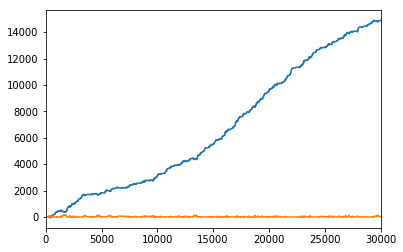

In [434]:
from matplotlib import pyplot as plt
pl["cum_pnl"].plot()
pl["drawdown"].plot()
plt.show()

In [382]:
pl = pnl_target(data_out, max_odds = 4, min_odds = 1.1, fee = 0.1, 
                target_restrict = None, scale_with_pred = True, 
                stake = 40, scale_with_odds = False, min_pred = 0.5)

0.03424713031735314
47.7097832949
118.955285918
620.513697998
4.01073251406


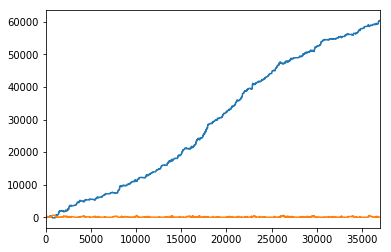

In [383]:
from matplotlib import pyplot as plt
pl["cum_pnl"].plot()
pl["drawdown"].plot()
plt.show()

In [333]:
pl.to_csv("pred_1.csv", sep = ";")

In [305]:
len(data_preprocessing)

137026

In [432]:
from sklearn.externals import joblib

class RFRPredictor():
    def __init__(self, pred_file, encoder_file, runners, stake = 4, target_restrict = None, 
                 scale_with_pred=None, scale_with_odds=None, min_odds = 1.01, 
                 max_odds = 1000, min_pred = 0):
        
        self.encoder_file = encoder_file
        self.pred_file = pred_file
        self.runners = runners
        self.stake = stake
        self.target_restrict = target_restrict
        self.scale_with_pred = scale_with_pred,
        self.scale_with_odds = scale_with_odds, 
        self.min_odds = min_odds
        self.max_odds = max_odds
        self.min_pred = min_pred
        self.models = read_models(self.pred_file, self.runners)
        self.encoder = read_encoder(self.encoder_file)
        
    def read_models(self, file, runners):
        models = {}
        for runner in runners:
            models[runner] = joblib.load(file+"_"+runner+".pkl")
        return models

    def read_encoder(self, file):
        return joblib.load(file+".pkl")

    def make_prediction(self, data):
        
        try:
            team1_label = self.encoder.transform([data["team1"]])[0]
            team2_label = self.encoder.transform([data["team2"]])[0]
        except ValueError:
            return {runner:-1000 for runner in runners}
        
        regressors = [[team1_label,team2_label,data["1"], data["x"], data["2"]]]
        print(regressors)
        pred = {}

        for runner in self.runners:
            pred[runner] = self.models[runner].predict(regressors)

        return pred

    def get_bet(self, odds):
        
        pred = self.make_prediction(odds)
        
        target = self.runners[0]
        for runner in self.runners:
            if float(pred[runner]) > float(pred[target]):
                target = runner

        restricted = self.target_restrict is None or target in self.target_restrict

        if pred[target] > self.min_pred and float(odds[target])<self.max_odds \
                    and float(odds[target])>self.min_odds and restricted:
            
            stake_adjusted = self.stake

            if self.scale_with_odds:
                stake_adjusted = stake_adjusted / float(odds[target])

            if self.scale_with_pred:
                stake_adjusted = stake_adjusted * max(min(pred[target], 5), 0.5)
            return target, stake_adjusted
        else:
            return None, 0


pred_file = "predictor"    
encoder_file = "encoder"
runners = ["1","x","2"]

predictor = RFRPredictor(pred_file, encoder_file, runners, stake = 10, max_odds = 3, min_odds = 1.2, 
        scale_with_pred = True, scale_with_odds = False, target_restrict = None,
        min_pred = 0)

odds = data_preprocessing.iloc[0]

predictor.get_bet(odds)


[[5715, 10146, 2.5, 3.8999999999999999, 5.2000000000000002]]


('1', 2.0)